## Selecting Models for Stacked Generalization Using Tabu Search  Algorithm
- [Tabu search](https://en.wikipedia.org/wiki/Tabu_search) (TS) is a metaheuristic search algorithm proposed by Fred W. Glover in 1986.
- TS is uses a memory based search structure to explore the search space. Solutions the are visited during the search are added to the memory (Tabu List) to prohibit the search from visiting the same solution. TS applies aspiration criterial to avoid the search getting stuck in a local suboptimal regions.
- In this work, TS is applied to search for the best combination of machine learning models to develop stacked generalization ensemble. 
- The objective is to select b base models from a pool B base models that provide the best performance when combined. 
    - All the learners are trained on the original dataset the out of fold predictions are generated.
    - A correlation matrix is generated from the correlation among the prediction result of the base classifiers.
    - All possible combination of b models generated and evaluated using the correlation among the constituent models.
    - List of neighborhood solutions are generated by randomly selecting from all possible combinations and ranked on correlation
    - The best solution from each neighborhood solutions are evaluated by training and testing the corresponding models. Then, F1-score will be used to evaluate and select the best solution.
    


#### 1. Import dataset

In [1]:
import pandas as pd
data = pd.read_csv("./Data/UCI_Credit_Card.csv",  delimiter=',', encoding='utf-8-sig')

***
###### Change the label column header (default.payment.next.month) with shorter header "DEFAULT"

In [3]:
data.rename(columns={'default.payment.next.month':'DEFAULT'}, inplace=True) 
# data.columns

#### Separate the label and the features

In [4]:
features = data.drop('DEFAULT',axis=1)
label = data['DEFAULT']
X = features
Y = label
# features.columns

***
#### Feature selection
These features are selected based on their importance; that will be explained in another notebook.

In [5]:
X = data[[u'LIMIT_BAL', u'SEX', u'EDUCATION', u'MARRIAGE', u'AGE', u'PAY_0', u'PAY_2', u'PAY_3', u'PAY_4', u'PAY_5', u'BILL_AMT1', u'PAY_AMT1']]
# X.columns


#### Split the data set to test and training set

In [6]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=0)
# x_train.columns

***
####  2. Train & Test base learners

###### Define the all the base learners and their hyperparameters 

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.ensemble import ExtraTreesClassifier 
from sklearn.ensemble import BaggingClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import RidgeClassifier
from catboost import CatBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import xgboost as xgb
import lightgbm as lgbm
SEED = 999
# Turn of all the warnings from sklearn
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

XGB_clf = xgb.XGBClassifier(learning_rate = 0.01,
                            n_estimators = 36,
                            max_depth = 6,
                            min_child_weight = 1,
                            # gamma=1,
                            gamma = 0,
                            subsample = 0.8,
                            colsample_bytree = 0.8,
                            objective = 'binary:logistic',
                            nthread = -1,
                            scale_pos_weight = 1)
   
RF_clf= RandomForestClassifier(n_jobs = -1,
                                n_estimators = 500,
                                 # warm_start = True,
                                 # max_features = 0.2,
                                max_depth = 6,
                                min_samples_leaf = 2,
                                max_features = 'sqrt',
                                verbose = 0)

# Extra Trees Parameters
ET_clf = ExtraTreesClassifier(
                                n_jobs = -1,
                                n_estimators = 500,
                                #'max_features': 0.5,
                                max_depth = 8,
                                min_samples_leaf = 2,
                                verbose = 0)



# SVM_clf=LinearSVC(C=1.0,random_state=0)
SVM_clf=SVC(kernel = 'rbf', C = 100, gamma = 'auto', max_iter=10000)  
KNN_clf = KNeighborsClassifier(n_neighbors=8, weights='uniform', n_jobs=4)

GBM_clf = GradientBoostingClassifier(n_estimators=1000,
                                 loss="exponential",
                                 # max_features=4,
                                 max_depth=3,
                                 subsample=0.5,
                                 learning_rate=0.005,
                                 random_state=SEED
                               )

ADAB_clf = AdaBoostClassifier(random_state=41,learning_rate=0.5,n_estimators=1000)


# Initializing Multilayer Perceptron
MLP_clf = MLPClassifier(hidden_layer_sizes=(50), 
                        batch_size=50, 
                        learning_rate='constant', 
                        learning_rate_init=0.005, 
                        early_stopping=True)

LR_clf = LogisticRegression(penalty='l1',C = 464,random_state = SEED, solver='liblinear')

LGBM_clf = lgbm.LGBMClassifier( seed = 32,
                                learning_rate = 0.01,
                                n_estimators = 1000,
                                nthread = 4,
                                max_depth = 6,
                                subsample = 1.0,
                                colsample_bytree = 0.75,
                                num_leaves = 54,
                                reg_alpha = 0.62,
                                reg_lambda = 2.9)

# Initializing CatBoost classifier
CATB_clf = CatBoostClassifier(iterations=500, 
                               learning_rate=0.1, 
                               depth=5, 
                               border_count = 10, 
                               logging_level='Silent', 
                               l2_leaf_reg=2, 
                               thread_count=4)

# Initializing Bernoulli naive-bayes classifier
BERNL_clf = BernoulliNB(alpha=1.0, 
                        binarize=0.0, 
                        class_prior=None, 
                        fit_prior=True)
# Initializing Gaussian naive-bayes classifier
GAUS_clf = GaussianNB(priors=None, var_smoothing=1e-09)

# Initializing decission tree classifier
DT_clf = DecisionTreeClassifier(max_leaf_nodes=10, max_depth=5)  

# Initializing Linear Discriminant Analysis classifier
LDA_clf = LinearDiscriminantAnalysis()

# Initializing bagging classifier: bagging of decission trees 
BAG_clf = BaggingClassifier(base_estimator=DT_clf, n_estimators=40, random_state=1, oob_score=True)


#### Train and test the base learners, collect out of fold base learners output to train and test metalearner

In [8]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.model_selection import KFold, StratifiedKFold
scaler = MinMaxScaler()
SEED = 222
NSPLIT = 5
kf = StratifiedKFold(n_splits=NSPLIT, random_state=SEED, shuffle=False)

# Base models out of fold predictions
def base_models_output(model, x_train, y_train, x_test):
    meta_train = np.zeros((x_train.shape[0],))
    meta_test = np.zeros((x_test.shape[0],))
    meta_test_fold = np.empty((NSPLIT, x_test.shape[0]))

    for i, (train_idx, test_idx) in enumerate(kf.split(x_train, y_train)):
        x_trainFold = x_train.iloc[train_idx]
        y_trainFold = y_train.iloc[train_idx]
        x_testFold = x_train.iloc[test_idx]
        # Train the base models on the folds
        if model == MLP_clf or model == SVM_clf or model == KNN_clf or model == GAUS_clf: #These models perform better on scalled values
            x_trainFold = scaler.fit_transform(x_trainFold)
            x_testFold = scaler.fit_transform(x_testFold)
            model.fit(x_trainFold, y_trainFold)
            meta_train[test_idx] = model.predict(x_testFold) # Predict the validation fold - to train the meta learner
            meta_test_fold[i, :] = model.predict(x_test) # Predict the test fold to test the meta learner --OOF predictions 
            
        else:        
            model.fit(x_trainFold, y_trainFold)
            # Collect the predition of the base models to train the metalearner
            meta_train[test_idx] = model.predict(x_testFold) # Predict the validation fold - to train the meta learner
            meta_test_fold[i, :] = model.predict(x_test) # Predict the test fold to test the meta learner --OOF predictions    
            
    meta_test[:] = meta_test_fold.mean(axis=0)
    # Reshape is to merge the rows from the folds, and return a single column vector for every model.
    return meta_train.reshape(-1, 1), meta_test.reshape(-1, 1)   

#### Collect the out fold of fold prediction score of the base classifier which will be used to train and test the meta classifier

In [9]:
RF_clf_meta_train, RF_clf_meta_test = base_models_output(RF_clf, x_train, y_train, x_test)
print('0: Random Forest train-test complete')
ET_clf_meta_train, ET_clf_meta_test = base_models_output(ET_clf, x_train, y_train, x_test)
print('1: Extra Tree train-test complete')
SVM_clf_meta_train, SVM_clf_meta_test = base_models_output(SVM_clf,x_train, y_train, x_test)
print('2: SVM train-test complete')
KNN_clf_meta_train, KNN_clf_meta_test = base_models_output(KNN_clf, x_train, y_train, x_test)
print('3: KNN train-test complete')
GBM_clf_meta_train, GBM_clf_meta_test = base_models_output(GBM_clf,x_train, y_train, x_test)
print('4: GBM train-test complete')
ADAB_clf_meta_train, ADAB_clf_meta_test = base_models_output(ADAB_clf,x_train, y_train, x_test)
print('5: AdaBoost train-test complete')
MLP_clf_meta_train, MLP_clf_meta_test = base_models_output(MLP_clf,x_train, y_train, x_test)
print('6: MLP train-test complete')
LR_clf_meta_train, LR_clf_meta_test = base_models_output(LR_clf,x_train, y_train, x_test)
print('7: Logistic Regression train-test complete')
LGBM_clf_meta_train, LGBM_clf_meta_test = base_models_output(LGBM_clf,x_train, y_train, x_test)
print('8: LGBM train-test complete')
CATB_clf_meta_train, CATB_clf_meta_test = base_models_output(CATB_clf,x_train, y_train, x_test)
print('9: CATB training complete')
BERNL_clf_meta_train, BERNL_clf_meta_test = base_models_output(BERNL_clf,x_train, y_train, x_test)
print('10: BERNL train-test complete')
GAUS_clf_meta_train, GAUS_clf_meta_test = base_models_output(GAUS_clf,x_train, y_train, x_test)
print('11: GAUS train-test complete')
DT_clf_meta_train, DT_clf_meta_test = base_models_output(DT_clf,x_train, y_train, x_test)
print('12: DT train-test complete')
LDA_clf_meta_train, LDA_clf_meta_test = base_models_output(LDA_clf,x_train, y_train, x_test)
print('13: LDA train-test complete')

print('BASE MODEL OUT OF FOLD PREDICTION COMPLETED!!')
# XGB_clf_meta_train, XGB_clf_meta_test = base_models_output(XGB_clf,x_train, y_train, x_test)
# print('XGBoost training complete')

0: Random Forest train-test complete
1: Extra Tree train-test complete
2: SVM train-test complete
3: KNN train-test complete
4: GBM train-test complete
5: AdaBoost train-test complete
6: MLP train-test complete
7: Logistic Regression train-test complete
8: LGBM train-test complete
9: CATB training complete
10: BERNL train-test complete
11: GAUS train-test complete
12: DT train-test complete
13: LDA train-test complete
BASE MODEL OUT OF FOLD PREDICTION COMPLETED!!


***
##### Combine the prediction output of all base classifiers for training and testing the meta classifier, the tabu search take columns from the concatenated numpy array based on the selected models: models are column headers 

In [10]:
all_meta_train = np.concatenate((RF_clf_meta_train, ET_clf_meta_train, SVM_clf_meta_train, KNN_clf_meta_train, 
                                 GBM_clf_meta_train, ADAB_clf_meta_train, MLP_clf_meta_train, LR_clf_meta_train,
                                 LGBM_clf_meta_train, CATB_clf_meta_train, BERNL_clf_meta_train, GAUS_clf_meta_train,
                                 DT_clf_meta_train, LDA_clf_meta_train), axis=1)

all_meta_test = np.concatenate((RF_clf_meta_test, ET_clf_meta_test, SVM_clf_meta_test, KNN_clf_meta_test, 
                                 GBM_clf_meta_test, ADAB_clf_meta_test, MLP_clf_meta_test, LR_clf_meta_test,
                                 LGBM_clf_meta_test, CATB_clf_meta_test, BERNL_clf_meta_test, GAUS_clf_meta_test,
                                 DT_clf_meta_test, LDA_clf_meta_test), axis=1)

***
###### Correlation Heatmap of the out of fold prediction of base classifiers 
- The correlation will be used in the TS to select combination of modes 

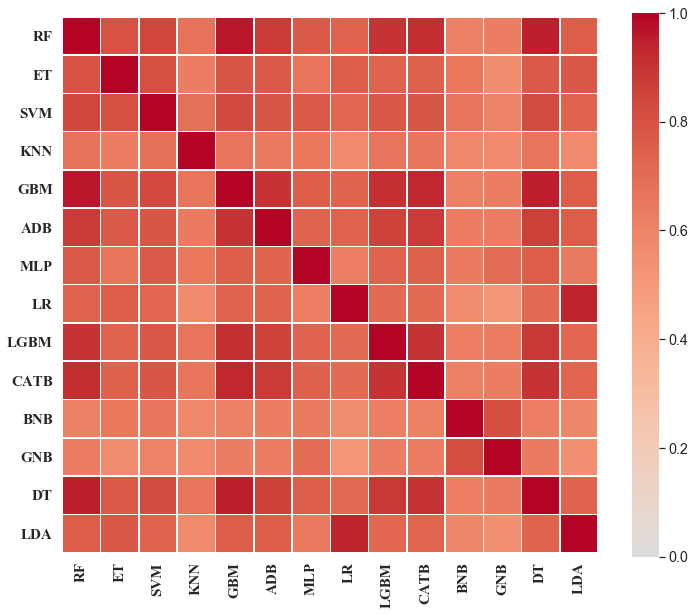

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
 
csfont = {'fontname':'Times New Roman'}
Base_oof = pd.DataFrame(all_meta_train, columns=['RF_clf_meta_train', 'ET_clf_meta_train', 'SVM_clf_meta_train', 'KNN_clf_meta_train', 
                                 'GBM_clf_meta_train', 'ADAB_clf_meta_train', 'MLP_clf_meta_train', 'LR_clf_meta_train',
                                 'LGBM_clf_meta_train', 'CATB_clf_meta_train', 'BERNL_clf_meta_train', 'GAUS_clf_meta_train',
                                 'DT_clf_meta_train', 'LDA_clf_meta_train'])
# Rename column headers, more clear visualization
Base_oof.columns = ['RF','ET', 'SVM', 'KNN', 'GBM', 'ADB', 'MLP', 'LR', 'LGBM', 'CATB','BNB', 'GNB', 'DT', 'LDA']

base_corr = Base_oof.corr()

f, ax = plt.subplots(figsize=(12, 10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

##"YlGnBu" "Blues" "BuPu" "Greens", 'viridis', 'coolwarm'
sns.heatmap(base_corr, cmap="coolwarm", vmin=0,vmax=1, center=0, square=True, linewidths=.5) 
loc, labels = plt.xticks()
ax.set_xticklabels(labels, fontSize=15, **csfont)
ax.set_yticklabels(labels, fontSize=15, rotation=0, **csfont)
sns.set(font_scale=1.3)

plt.show()

f.savefig("modCorr.pdf", bbox_inches='tight')

#### 3. Tabu Search for model selection

###### Prepare the predicted output of the base models based on the solution (combination of base models)

In [13]:
def prep_metaDatsetTS(all_meta_train, all_meta_test, y_train, y_test, soln):
    # turn off all sklearn warnings: data conversion, deprecation warnings
    def warn(*args, **kwargs):
        pass
    
    import warnings
    warnings.warn = warn
    
    # Convert solution to list, and the elements has to be of type int since they are used to slice indexes from array
    soln = [int(i) for i in soln[:-2]] # the last 2 element holds correlation and f1, not required here
    
    #slice the meta dataset based on the solution (all_meta_train and all_meta_test) has twelve columns corresponding to 12 base
    #models, solution list has five elements. Five columns are sliced from the 12 columns
    train_set = all_meta_train[:,soln]
    test_set = all_meta_test[:,soln]
    
    # Convert the train and test sets to Dmatrix format, for xgboost efficiency  
    dmeta_train = xgb.DMatrix(train_set, y_train)
    dmeta_test = xgb.DMatrix(test_set, y_test)

    return dmeta_train, dmeta_test

##### Calculate the fitness and append it to the last column for all the population, this is only done once for the entire operation (for local search)

In [14]:
def fitness_corr(sol):
    #print(sol)
    for s in range (len(sol)):
        soln = (sol[s,:-1].astype(int)).tolist()
        fitness = 0
        for i in soln:
            j = i+1
            for j in soln:
                if i<j:
                    fitness += base_corr_matrix[i,j]
        sol[s, -1] = fitness # append it to the last column
        
    # sort the solution
    rank=np.argsort(sol[:,-1]) 
    sol = sol[rank] 
    return sol

__Calculate the fitness based on the F1 score, train and test the meta learner on the prediction output of the selected base models (for global search).__

In [15]:
def fitness_f1Score(param, meta_train, meta_test, y_test):
    from sklearn.metrics import f1_score
    num_round = 100
    xgb_clf = xgb.train(param, meta_train, num_round)
    preds = xgb_clf.predict(meta_test)
    preds = preds>0.5
    fitness = round((f1_score(y_test, preds, average='weighted')), 4)  
  
    return fitness

###### Classification report of the metaclassifier, to compute accuracy and other performance measures of the final solution 

In [16]:
def class_report(param, meta_train, meta_test, y_test):
    from sklearn.metrics import precision_recall_fscore_support, accuracy_score
    num_round = 100
    # precision_recall_fscore 
    xgb_clf = xgb.train(param, meta_train, num_round)
    pred = xgb_clf.predict(meta_test)
    pred = [round(value) for value in pred]
    report = precision_recall_fscore_support(y_test, pred, average='weighted')
    # Accuracy
    accuracy = accuracy_score(y_test, pred)

    return report, accuracy 

#### Create initial population by chosing 'sel_clfs' from total classifiers 'num_clfs'

In [17]:

def init_solution(num_clfs, sel_clfs):
#     global population
    import itertools
    from itertools import combinations  
    clfs = np.arange(num_clfs)
    solution = np.array(list(itertools.combinations(np.arange(num_clfs), sel_clfs))) # generate array of combinations
    solution = np.append(solution, np.zeros((len(solution), 1)), axis=1) # append 1 last column to hold fitness
    solution = fitness_corr(solution) # compute fitness and add it to the solution
    return solution

#### Create a list neighborhood solution by randomly selecting from the solution

In [18]:
def create_neighbours(soln, num_train):
    import random
    popSize = len(soln) # will be global
    nb_index = random.sample(range(0, popSize), round(popSize/num_train)) 
    neighbours = np.stack([soln[i] for i in nb_index])
    return neighbours 

#### Main Tabu search algorithm starts here

In [19]:
def run_TabuSearch(parameters, num_train, all_meta_train, all_meta_test, y_train, y_test):
    global best_sol_rec 
    best_sol_rec = []
    solution = init_solution(14, 5)
    best_nbr = [0]*7 # Best solution in the neighborhood (based on correlation), the last two position holds corr and f1-score
    best_soln = [0]*7 #Best solution so far (based on F1 score) -> +1 is to hold f1-score  
    Tabu = []


    # Create n group of neighborhood solution, the number of neighborhood solution depending on how many times we want to train 
    # the model, only one best solution from neighborhood (less correlation) is trained. E.g. if we want to train the model 
    # only 8 times, we create 8 neighborhood solution with size 2002/8 = 250, and one solution from each 250 is trained (the one with
    # low correlation). NB 2002 = 14C5 -> total ways of choosing 5 model combinations from 14 base models.

    for n in range(num_train): 

        # Generate neighborhood solutions
        neighbors = create_neighbours(solution, num_train)
        # Sort the neighborhood solution, they are unsorted because they are randomly selected from the population
        rank=np.argsort(neighbors[:,-1]) 
        neighbors = neighbors[rank] 
        for j in range (len(neighbors)):
            # If neighbors[j] is in Tabu(already trained) go for the second best (neighbors[j+1]) and so forth 
            if not neighbors[j].tolist() in Tabu:  
                best_nbr[:-1] = neighbors[j].tolist()
                break

        if not best_nbr in Tabu:
            #print('Train and test:', best_nbr)
            Tabu.append(best_nbr[:-1])

            # Train and test the best in the neighborhood solution to find the f1-score
            meta_train, meta_test = prep_metaDatsetTS(all_meta_train, all_meta_test, y_train, y_test, best_nbr)
            fitness = fitness_f1Score(parameters, meta_train, meta_test, y_test) 
            
            # Add fitness(f1-score) at the end after correlation
            best_nbr[-1] = fitness

            # If f1-score of the best_nbr is better than f1-score of the best solution(best_soln), then update best_soln.
#             print (best_nbr[-1], '=============================', best_soln[-1])
            if best_nbr[-1] >  best_soln[-1]:
                best_soln = best_nbr
                best_nbr = []*7
#         print('iteration: ', n, 'best soln', best_soln, 'correlation->', best_soln[-2], 'F1 score->', best_soln[-1])
        best_sol_rec.append(best_soln[-1]) 
    print('best soln', best_soln, 'correlation->', best_soln[-2], 'F1 score->', best_soln[-1])   
    print('Selected models are:')
    for i in best_soln[:-2]:
        print (base_model[int(i)])

# Plot Ts solution

In [20]:
def plot_TS_solution(num_train, sol):
    import matplotlib
    import matplotlib.pyplot as plt
    # Generate a figure with matplotlib</font>
    figure = matplotlib.pyplot.figure(  )
    plot   = figure.add_subplot (111)

    iteration = np.arange (0, num_train)
    fitness =  [f*100 for f in sol]

    # optim_sol = max(fitness)
    # optim_index = numpy.where(fitness==optim_sol)
    # optim_index = int(optim_index[0])



    plt.plot(iteration, fitness, 'gs', iteration, fitness, 'b--')
    plt.ylabel('F1-score',fontsize=14)
    plt.xlabel('Iterations',fontsize=14)
#     plt.title('Solution convergence over generations')
    plt.tick_params(axis='both',labelsize=14)
    plt.show

#### Define the global parameters and set up the inputs to start the algorith

In [21]:
#Mapping the column indeces with corresponding classifiers, only used to print out the solution.
#model names instead of just their coumn index in the combined array
base_model = {0:'Random Forest', 
              1:'Extra Trees', 
              2:'Support Vector Machine', 
              3:'K-Nearest Neighbor', 
              4:'Gradient Boosting',
              5:'AdaBoost', 
              6:'Multi-layer Perceptron', 
              7:'Logistic Regression',
              8:'LightGBM', 
              9:'CatBoost', 
              10:'Bernoulli Naive Bayes', 
              11:'Gaussian Naive Bayes',
              12:'Decission Tree Classifier', 
              13:'Linear Discriminant Analysis'}

#parameters returned from ES
ESparameters = {'objective':'binary:logistic',
          'learning_rate': 2.100e-02,
          'n_estimators': 1252,
          'max_depth': 5,
          'min_child_weight': 2.0,
          'gamma':  5.000e-01,
          'subsample': 3.350e-01,
          'colsample_bytree': 1.0,
          'seed': 42,
          'silent':1}

base_corr_matrix = base_corr.values # correlation matrix of the base models to compute fitness from
num_train = 300


### Start TS

In [22]:
import time ## TS 1000 round -> 69.14113140106201, 200->136.28466796875
start = time.time()

run_TabuSearch(ESparameters, num_train, all_meta_train, all_meta_test, y_train, y_test)

end = time.time()
print('Tabu Search Computational time(sec) is:',end - start, 'iteration:', num_train)

best soln [1.0, 6.0, 7.0, 9.0, 13.0, 7.335562788262043, 0.8103] correlation-> 7.335562788262043 F1 score-> 0.8103
Selected models are:
Extra Trees
Multi-layer Perceptron
Logistic Regression
CatBoost
Linear Discriminant Analysis
Tabu Search Computational time(sec) is: 161.6193745136261 iteration: 300


#### TSNE visualization:
To explore the prediction results of each model in the feature space, t-SNE visualization can be used. The dimension of the feature space is reduced to two dimensions for better visualizations. From such visualizations, it can be seen that some models perform better than other in the feature space.

#### Reshape prediction outputs of base models: for plotting heatmap correlation and TSNE

In [26]:
RF_clf_preds    = RF_clf_meta_train.reshape((-1,)).astype(int)
ET_clf_preds    = ET_clf_meta_train.reshape((-1,)).astype(int)
SVM_clf_preds   = SVM_clf_meta_train.reshape((-1,)).astype(int)
KNN_clf_preds   = KNN_clf_meta_train.reshape((-1,)).astype(int)
GBM_clf_preds   = GBM_clf_meta_train.reshape((-1,)).astype(int)
ADAB_clf_preds  = ADAB_clf_meta_train.reshape((-1,)).astype(int)
MLP_clf_preds   = MLP_clf_meta_train.reshape((-1,)).astype(int) 
LR_clf_preds    = LR_clf_meta_train.reshape((-1,)).astype(int)
LGBM_clf_preds  = LGBM_clf_meta_train.reshape((-1,)).astype(int)
CATB_clf_preds  = CATB_clf_meta_train.reshape((-1,)).astype(int)
BERNL_clf_preds = BERNL_clf_meta_train.reshape((-1,)).astype(int) 
GAUS_clf_preds  = GAUS_clf_meta_train.reshape((-1,)).astype(int)

CATB_clf_preds.shape

(24000,)

#### Convert the test dataset to two dimensional array using tsne

In [23]:

from sklearn.manifold import TSNE
X_train = x_train.values
tsne = TSNE(n_components=2)
X_train_tsne = tsne.fit_transform(X_train)

#### Visualizing the scatter plot of prediction output of the base classifiers

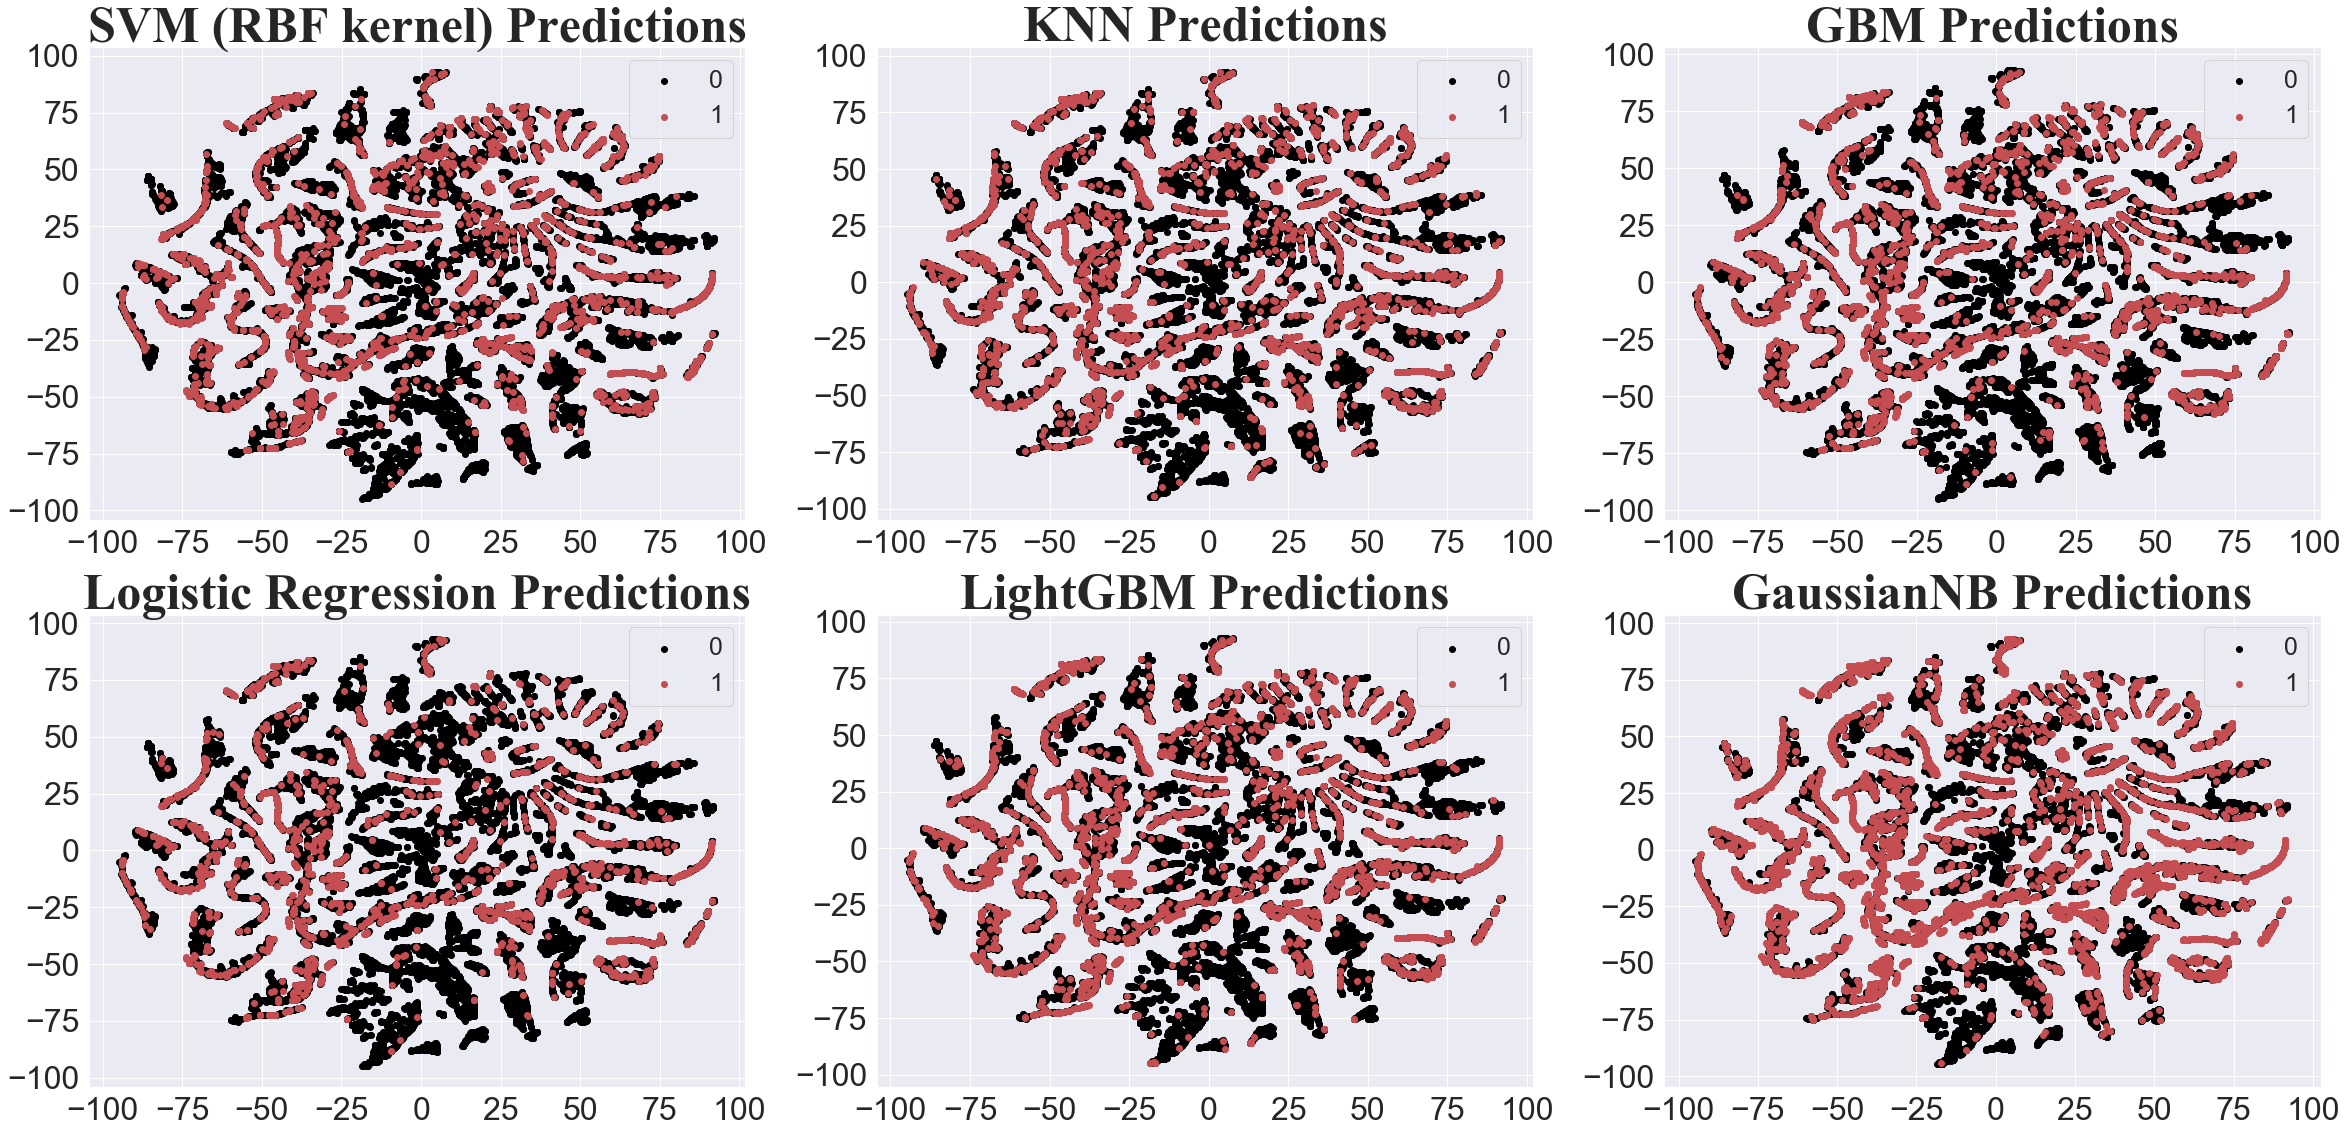

In [37]:
import matplotlib
import matplotlib.pyplot as plt
color_map = {0:"black", 1:"r"}
csfont = {'fontname':'Times New Roman'}
# plt.figure(figsize=(40, 40))
# # plt.subplots(6, 2, sharex=True, sharey=True)

# plt.subplot(431)
# for idx, cl in enumerate(np.unique(CATB_clf_preds)):
#     plt.scatter(X_train_tsne[CATB_clf_preds==cl,0], X_train_tsne[CATB_clf_preds==cl,1], c = color_map[idx], label = cl)
# plt.legend(loc='upper right', fontsize=30)
# plt.title('Catboost Predictions', size=50, **csfont)
# plt.xticks(fontsize=32)
# plt.yticks(fontsize=32)
# plt.grid(True)

# plt.subplot(432)
# for idx, cl in enumerate(np.unique(RF_clf_preds)):
#     plt.scatter(X_train_tsne[RF_clf_preds==cl,0], X_train_tsne[RF_clf_preds==cl,1], c = color_map[idx], label = cl)
# plt.legend(loc='upper right', fontsize=30)
# plt.title('RandomForest Predictions', size=50, **csfont)
# plt.xticks(fontsize=32)
# plt.yticks(fontsize=32)
# plt.grid(True)

# plt.subplot(433)
# for idx, cl in enumerate(np.unique(ADAB_clf_preds)):
#     plt.scatter(X_train_tsne[ADAB_clf_preds==cl,0], X_train_tsne[ADAB_clf_preds==cl,1], c = color_map[idx], label = cl)
# plt.legend(loc='upper right', fontsize=30)
# plt.title('Adaboost Predictions', size=50, **csfont)
# plt.xticks(fontsize=32)
# plt.yticks(fontsize=32)
# plt.grid(True)

# plt.subplot(434)
# for idx, cl in enumerate(np.unique(BERNL_clf_preds)):
#     plt.scatter(X_train_tsne[BERNL_clf_preds==cl,0], X_train_tsne[BERNL_clf_preds==cl,1], c = color_map[idx], label = cl)
# plt.legend(loc='upper right', fontsize=30)
# plt.title('Bernoulli Predicitons', size=50, **csfont)
# plt.xticks(fontsize=32)
# plt.yticks(fontsize=32)
# plt.grid(True)

# plt.subplot(435)
# for idx, cl in enumerate(np.unique(MLP_clf_preds)):
#     plt.scatter(X_train_tsne[MLP_clf_preds==cl,0], X_train_tsne[MLP_clf_preds==cl,1], c = color_map[idx], label = cl)
# plt.legend(loc='upper right', fontsize=30)
# plt.title('Multi-layer Perceptron Predictions', size=50, **csfont)
# plt.xticks(fontsize=32)
# plt.yticks(fontsize=32)
# plt.grid(True)

# plt.subplot(436)
# plt.rc('grid', linestyle="-", color='black')
# for idx, cl in enumerate(np.unique(ET_clf_preds )):
#     ax = plt.scatter(X_train_tsne[ET_clf_preds ==cl,0], X_train_tsne[ET_clf_preds ==cl,1], c = color_map[idx], label = cl)
# plt.legend(loc='upper right', fontsize=30)
# plt.title('ExtraTrees Predictions', size=50, **csfont)
# plt.xticks(fontsize=32)
# plt.yticks(fontsize=32)
# plt.grid(True)

# plt.show()
# f.savefig("TSNE_model1.pdf", bbox_inches='tight')


# Plot the remaining plots

f = plt.figure(figsize=(40, 40))
plt.subplot(431)
for idx, cl in enumerate(np.unique(SVM_clf_preds)):
    plt.scatter(X_train_tsne[SVM_clf_preds==cl,0], X_train_tsne[SVM_clf_preds==cl,1], c = color_map[idx], label = cl)
plt.legend(loc='upper right', fontsize=25)
plt.title('SVM (RBF kernel) Predictions',size=50, **csfont)
plt.xticks(fontsize=32)
plt.yticks(fontsize=32)
plt.grid(True)

plt.subplot(432)
for idx, cl in enumerate(np.unique(KNN_clf_preds)):
    plt.scatter(X_train_tsne[KNN_clf_preds==cl,0], X_train_tsne[KNN_clf_preds==cl,1], c = color_map[idx], label = cl)
plt.legend(loc='upper right', fontsize=25)
plt.title('KNN Predictions', size=50, **csfont)
plt.xticks(fontsize=32)
plt.yticks(fontsize=32)
plt.grid(True)

plt.subplot(433)
for idx, cl in enumerate(np.unique(GBM_clf_preds)):
    plt.scatter(X_train_tsne[GBM_clf_preds==cl,0], X_train_tsne[GBM_clf_preds==cl,1], c = color_map[idx], label = cl)
plt.legend(loc='upper right', fontsize=25)
plt.title('GBM Predictions', size=50, **csfont)
plt.xticks(fontsize=32)
plt.yticks(fontsize=32)
plt.grid(True)

plt.subplot(434)
for idx, cl in enumerate(np.unique(LR_clf_preds)):
    plt.scatter(X_train_tsne[LR_clf_preds==cl,0], X_train_tsne[LR_clf_preds==cl,1], c = color_map[idx], label = cl)
plt.legend(loc='upper right', fontsize=25)
plt.title('Logistic Regression Predictions', size=50, **csfont)
plt.xticks(fontsize=32)
plt.yticks(fontsize=32)
plt.grid(True)

plt.subplot(435)
for idx, cl in enumerate(np.unique(LGBM_clf_preds)):
    plt.scatter(X_train_tsne[LGBM_clf_preds==cl,0], X_train_tsne[LGBM_clf_preds==cl,1], c = color_map[idx], label = cl)
plt.legend(loc='upper right', fontsize=25)
plt.title('LightGBM Predictions', size=50, **csfont)
plt.xticks(fontsize=32)
plt.yticks(fontsize=32)
plt.grid(True)


plt.subplot(436)
for idx, cl in enumerate(np.unique(GAUS_clf_preds)):
    plt.scatter(X_train_tsne[GAUS_clf_preds==cl,0], X_train_tsne[GAUS_clf_preds==cl,1], c = color_map[idx], label = cl)
plt.legend(loc='upper right', fontsize=25, )
plt.title('GaussianNB Predictions', size=50, **csfont)
plt.xticks(fontsize=32)
plt.yticks(fontsize=32)
# plt.grid(True)

plt.show()
f.savefig("TSNE_model2.pdf", bbox_inches='tight')

#### Confusion matrix and ROC curve of the meta learner evaluated on the prediction output of the selected base level models

In [1594]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score, log_loss, accuracy_score, confusion_matrix

def plot_cm(ax, y_true, y_pred, classes, title, th=0.5, cmap=plt.cm.Blues):
    y_pred_labels = (y_pred>th).astype(int)
    
    cm = confusion_matrix(y_true, y_pred_labels)
    
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title,  fontsize=20, weight='heavy')

    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes, fontsize=16, weight='heavy')
    ax.set_yticklabels(classes, fontsize=16, weight='heavy')
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, cm[i, j], fontsize=16, weight='heavy',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    ax.set_ylabel('True Label', fontsize=16, weight='heavy')
    ax.set_xlabel('Predicted Label',  fontsize=16, weight='heavy')

def plot_auc(ax, y_train, y_train_pred, y_test, y_test_pred, th=0.5):

    y_train_pred_labels = (y_train_pred>th).astype(int)
    y_test_pred_labels  = (y_test_pred>th).astype(int)

    fpr_train, tpr_train, _ = roc_curve(y_train,y_train_pred)
    roc_auc_train = auc(fpr_train, tpr_train)
    acc_train = accuracy_score(y_train, y_train_pred_labels)

    fpr_test, tpr_test, _ = roc_curve(y_test,y_test_pred)
    roc_auc_test = auc(fpr_test, tpr_test)
    acc_test = accuracy_score(y_test, y_test_pred_labels)

    ax.plot(fpr_train, tpr_train)
    ax.plot(fpr_test, tpr_test)

    ax.plot([0, 1], [0, 1], 'k--')

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',  fontsize=16, weight='heavy')
    ax.set_ylabel('True Positive Rate',  fontsize=16, weight='heavy')
    ax.set_title('ROC Curve',  fontsize=20, weight='heavy')
#     ax.set_xticklabels(xticks, fontsize=12,  rotation =45)
    plt.xticks(fontsize=14, weight='heavy')
    plt.yticks(fontsize=14, weight='heavy')
    
    train_text = 'train acc = {:.3f}, auc = {:.2f}'.format(acc_train, roc_auc_train)
    test_text = 'test acc = {:.3f}, auc = {:.2f}'.format(acc_test, roc_auc_test)
    ax.legend([train_text, test_text], fontsize=13)

In [1595]:
dtrain = xgb.DMatrix(meta_train, y_train)
dtest = xgb.DMatrix(meta_test, label=y_test)
num_round = 5
evallist  = [(dtest,'eval'), (dtrain,'train')]
param = {'objective':'binary:logistic', 'silent':1, 'eval_metric': ['error', 'logloss']}

bst = xgb.train( param, dtrain, num_round, evallist )

[0]	eval-error:0.169833	eval-logloss:0.590802	train-error:0.180333	train-logloss:0.581018
[1]	eval-error:0.169833	eval-logloss:0.534572	train-error:0.180333	train-logloss:0.522532
[2]	eval-error:0.169833	eval-logloss:0.501551	train-error:0.180333	train-logloss:0.490017
[3]	eval-error:0.169833	eval-logloss:0.481556	train-error:0.180333	train-logloss:0.471638
[4]	eval-error:0.169833	eval-logloss:0.469202	train-error:0.180333	train-logloss:0.461294


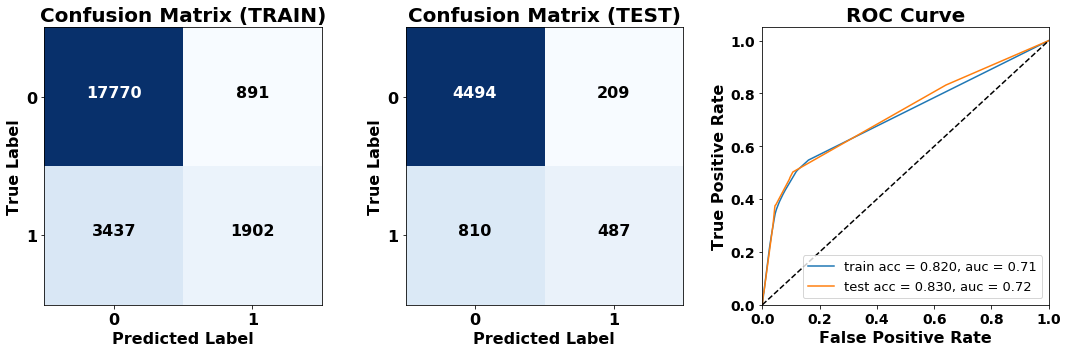

In [1596]:
threshold = 0.5
y_train_pred = bst.predict(dtrain)
y_test_pred = bst.predict(dtest)

fig,ax = plt.subplots(1,3)
fig.set_size_inches(15,5)

plot_cm(ax[0],  y_train, y_train_pred, [0,1], 'Confusion Matrix (TRAIN)', threshold)
plot_cm(ax[1],  y_test, y_test_pred,   [0,1], 'Confusion Matrix (TEST)', threshold)
plot_auc(ax[2], y_train, y_train_pred, y_test, y_test_pred, threshold)
    
plt.tight_layout()
plt.show()